# A/B-тестирование

**Цель работы** - оценка изменения бизнес метрик после введения новой системы рекомендаций пользователям.

На изучение поставлены следующие задачи:
1. Определение корректности проведения теста:
  * соответствие условий требованиям технического задания;
  * пересечение с конкурирующими тестами;
  * совпадение маркетинговых событий;
  * равномерность распределения по тестовым группам;
  * особенности проведения A/B-теста.
2. Исследовательский анализ:
* воронку взаимодействия пользователя с системой;
* разница взаимодействий по событиям в выборках;
* изменение конверсии на разных этапах;
3. Анализ результатов A/B-тестирования:
* исследование результатов A/B-эксперимента после смены системы рекомендаций;
* статистическая разница долей z-критерий.


**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.


`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.


`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.


`final_ab_participants.csv` — таблица участников тестов.
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Шаг 1. Изучение общей информации. Подготовка данных.

In [1]:
# импрортируем библиотеки
import pandas as pd
from scipy import stats as st
import datetime as dt
from datetime import datetime, date, time
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

import seaborn as sns

import math as mth
from plotly import graph_objects as go


import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import pylab

In [2]:
# считываем данные csv-файла в датафреймы и сохраняем в переменные
# <загрузка данных>

Выведем первые строчки датафреймов на экран и основную информацию о датафреймах с помощью метода `info()` для ознакомления с исследуемыми данными.

<вывод> final_ab_events.head()

<вывод> final_ab_events.info()

<вывод> ab_project_marketing_events.head()

<вывод> ab_project_marketing_events.info()

<вывод> final_ab_new_users.head()

<вывод> final_ab_new_users.info()

<вывод> final_ab_participants.head()

<вывод> final_ab_participants.info()

#### Работа с пропусками

Выведем количество пропущенных значений для каждого столбца. Используйте комбинацию двух методов `isnull()` и `sum()`.

In [11]:
final_ab_events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Обнаруженно большое количество пропусков по столбцу с дополнением к событию, проверим, какие события есть в таблице, и к чему относятся пропуски.

In [12]:
final_ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [13]:
final_ab_events.query('event_name	!= "purchase"')['user_id'].count()

377577

In [14]:
ab_project_marketing_events.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [15]:
final_ab_new_users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [16]:
final_ab_participants.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

Пропуски обнаружены только по столбцу дополнительных данных о событии датафрейма `final_ab_events`, так он имеет данные только на побытии покупка.


#### Изменение типов данных

In [17]:
# изменяем тип данных о дате события датафрейма final_ab_events на `datetime`
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
# добавление столбца с днем
final_ab_events['day'] = final_ab_events['event_dt'].astype('datetime64[D]')

In [18]:
# изменяем тип данных о дате начала и завершения компании датафрейма ab_project_marketing_events на `datetime`
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

In [19]:
# изменяем тип данных о дате регестрации датафрейма final_ab_new_users на `datetime`
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])


#### Поиск дубликатов

In [20]:
final_ab_events.duplicated().sum()

0

In [21]:
ab_project_marketing_events.duplicated().sum()

0

In [22]:
final_ab_new_users.duplicated().sum()

0

In [23]:
final_ab_participants.duplicated().sum()

0

Явных дубликатов необнаружено.

#### Изучение тестов

In [24]:
# количество проводимых тестов
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [25]:
# количество пользователей в каждом тесте
final_ab_participants.groupby('ab_test').agg({'user_id':'nunique'}).reset_index()

,ab_test,user_id
0,interface_eu_test,11567
1,recommender_system_test,6701


Представлены два теста, по изменению интерфейса на европейскую аудиторию и изменение системы рекомендаций. В первый тест вовлечена большая часть пользователей 11567, во втором тесте участвует 6701 пользователь.

### Шаг 2. Корректность проведения теста

Проверяем соответствие данных требованиям технического задания

#### Соответствие дат требованиям технического задания

Дата запуска теста: 07.12.2020

In [26]:
# определяем минимальную дату начала набора пользователей в группы
final_ab_new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Дата запуска теста совпадает с началом набора пользователей.

Дата остановки набора новых пользователей: 2020-12-21

In [27]:
# определяем максимальную дату начала набора пользователей в группы
#final_ab_new_users['first_date'].max()
final_ab_participants.merge(final_ab_new_users, on = 'user_id', how = 'left')\
.query('ab_test == "recommender_system_test"')['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки надора пользователей в группы исследуемого теста соответствует заданию.

Оценка теста определяется по достижению повешения метрик на 14й день после регистрации, т.е. события пользователей учитываются до даты окончания теста по 04.01.2021.

In [28]:
# день последней регистрации событий пользователей
final_ab_events['day'].max()

Timestamp('2020-12-30 00:00:00')

Тест продолжиется до 4 января, но последнее событие зарегестроравано 30 декабря. В данном случае следовало бы проверить систему сбора данных, либо возникновение технических ошибок, т.к. маловероятно, что все пользователи разом прекратили осуществление покупок.


#### Аудитория: 15% новых пользователей из региона EU

1. Определить долю участвующих в тесте от всех новых пользователей.
2. Проверить, являются ли аудитория теста 15% новых пользователей из региона EU.

In [29]:
# пользователи участвующие в исследуемом тесте
audit_test = final_ab_participants.query('ab_test == "recommender_system_test"')

In [30]:
print(f'Количество новых пользователей составляет {final_ab_new_users["user_id"].nunique()}')
print(f'Количество пользователей, участвующих в тесте - {audit_test["user_id"].nunique()}, '
     f'что составляет {round(audit_test["user_id"].nunique()*100/final_ab_new_users["user_id"].nunique(),2)}% от всех новых пользователей.')

Количество новых пользователей составляет 61733
Количество пользователей, участвующих в тесте - 6701, что составляет 10.85% от всех новых пользователей.


In [31]:
# количество новых пользователей из Евросоюза, пришедших в период набора пользователей в тест
audit_eu = (
    final_ab_new_users
    .query('region == "EU" & first_date <= "2020-12-21" & first_date >= "2020-12-07"')
)

# пользователи Евросоюза, участвующие в тесте
audit_eu_test = audit_eu.query('user_id in @audit_test.user_id')

In [32]:
print(f'Количество новых пользователей из региона EU составляет {audit_eu["user_id"].nunique()}')
print(f'Количество пользователей из региона EU, участвующих в тесте - {audit_eu_test["user_id"].nunique()}, '
      f'что составляет {round(audit_eu_test["user_id"].nunique()*100/audit_eu["user_id"].nunique(),2)}% '
      f'от всех новых пользователей из региона EU.')

Количество новых пользователей из региона EU составляет 42340
Количество пользователей из региона EU, участвующих в тесте - 6351, что составляет 15.0% от всех новых пользователей из региона EU.


Количество новых пользователей составляет 61733, из них 42340 являются представителями европейской аудитории. Количество пользователей, участвующих в тесте - 6701, что составляет 10.85% от всех новых пользователей. Количество пользователей из региона EU, участвующих в тесте - 6351, что составляет 15.0% от всех новых пользователей из региона EU.

По ТЗ ожидаемое количество участников теста: 6000. В таком случае пересмотрим соотношение по пользователям из Евросоюза.

In [33]:
test_users = 6000
print(f'Пользователей из Евросоюза {audit_eu_test["user_id"].nunique()}, что составляет '
    f'{round(audit_eu_test["user_id"].nunique()*100/test_users,2)}% от ожидаемого числа участников теста '
    f'и {round(audit_eu_test["user_id"].nunique()*100/audit_test["user_id"].nunique(),2)}% от '
    f'фактического числа участников теста')

Пользователей из Евросоюза 6351, что составляет 105.85% от ожидаемого числа участников теста и 94.78% от фактического числа участников теста


При соблюдении условия, что участников теста должно быть 6000 пользователей, то требования соблюдаются, т.к. пользователей, участвующих в тесте, из Евросоюза 6351. В целом, новых клиентов региона EU 42340, и доля участвующих в тесте среди них составляет 15%, что соответсвует требованиям.

#### Маркетинговые события

In [34]:
# выводим маркетинговые события, дата которых попадает на время теста
ab_project_marketing_events.query('start_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


На дату теста выпадает два маркетинговых события, что может исказить результаты. Так как такие события влияют на обе группы, можно пренебречь данным обстоятельтсвом, но следует отметить, что в таком случае не будет точной уверенности, что повлияло на активность пользователей, события или изменения в системе рекомендаций. К тому же, даже без этих маркетинговых событий, конец года в предверии праздничных дней характеризуется повышенной активностью пользователей. Прием пользователей оканчивается до начала компаний.

#### Аудитория теста

Представлены ли пользователи в двух группах

In [35]:
# проверим пересечение групп по пользователям
audit_test.groupby('user_id').agg({'group':'nunique'}).reset_index().query('group > 1')['user_id'].count()

0

Пользователи теста не пересекаются в группах.

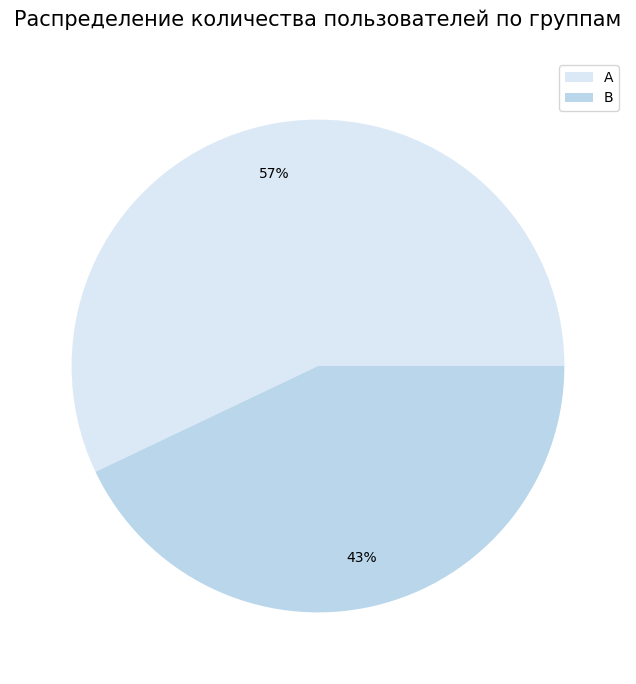

,group,user_id
0,A,3824
1,B,2877


In [36]:
# формируем таблицу по группам теста и посчитаем количество уникальных клиентов
audit_test_group = audit_test.groupby('group').agg({'user_id':'nunique'}).reset_index()
                 
# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(audit_test_group['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение количества пользователей по группам' + "\n", fontsize=15)
plt.legend(audit_test_group['group'])
plt.show()

audit_test_group

В группу `A` входит 3824 пользователя, в группу `B` - 2877. Распределение в долях по группам 57% к 43% соответственно.

#### Динамика регистраций пользователей теста 

In [37]:
# таблица пользователей теста с датой регистрации и группой
audit_test_reg = audit_test.merge(final_ab_new_users, on='user_id', how='left')

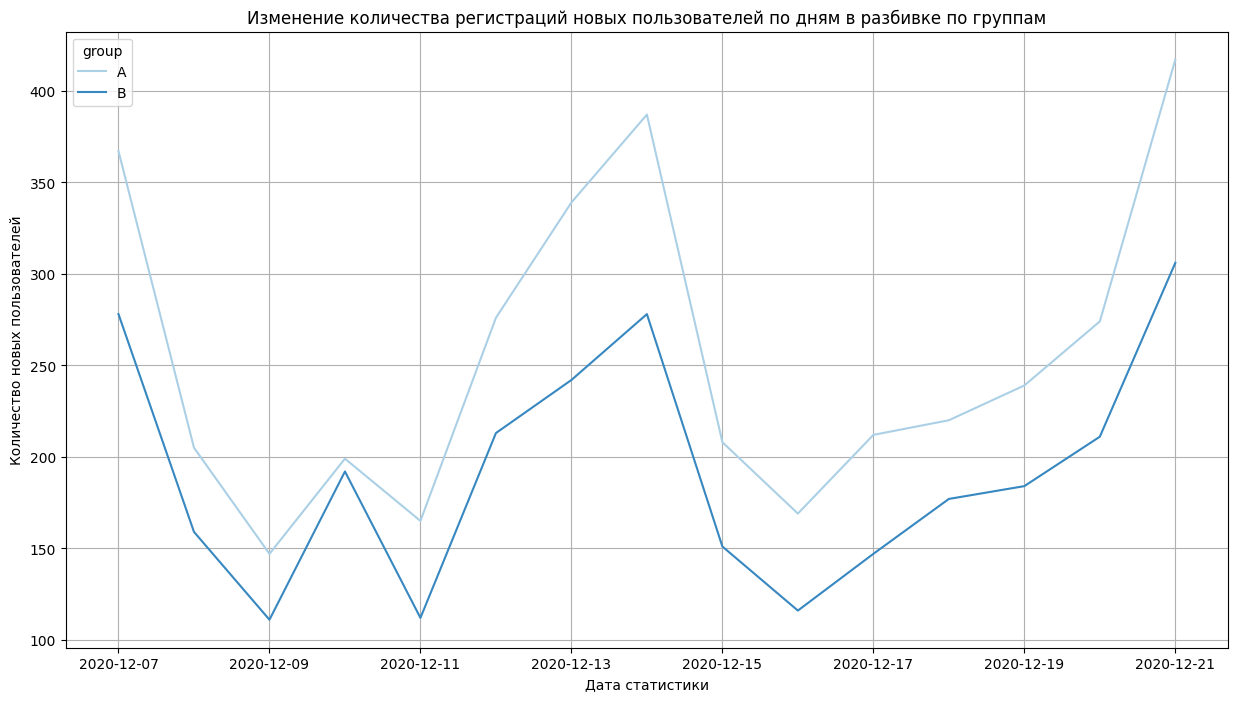

In [38]:
# подготавливаем таблицу сгруппированную по дням и группе теста с расчетом уникальных пользователей
audit_test_reg_day = audit_test_reg.groupby(['first_date', 'group']).agg({'user_id':'nunique'}).reset_index()

# строим линейный график изменения количества количества событий по дням
plt.figure(figsize=(15,8))
sns.lineplot(data=audit_test_reg_day, x='first_date', y='user_id', hue='group', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Количество новых пользователей')
plt.title('Изменение количества регистраций новых пользователей по дням в разбивке по группам')
plt.show()

Особых различий в динамике регистраций не наблюдается. Пользователи разных групп приходили с одинаковым темпом.

#### Параллельные тесты

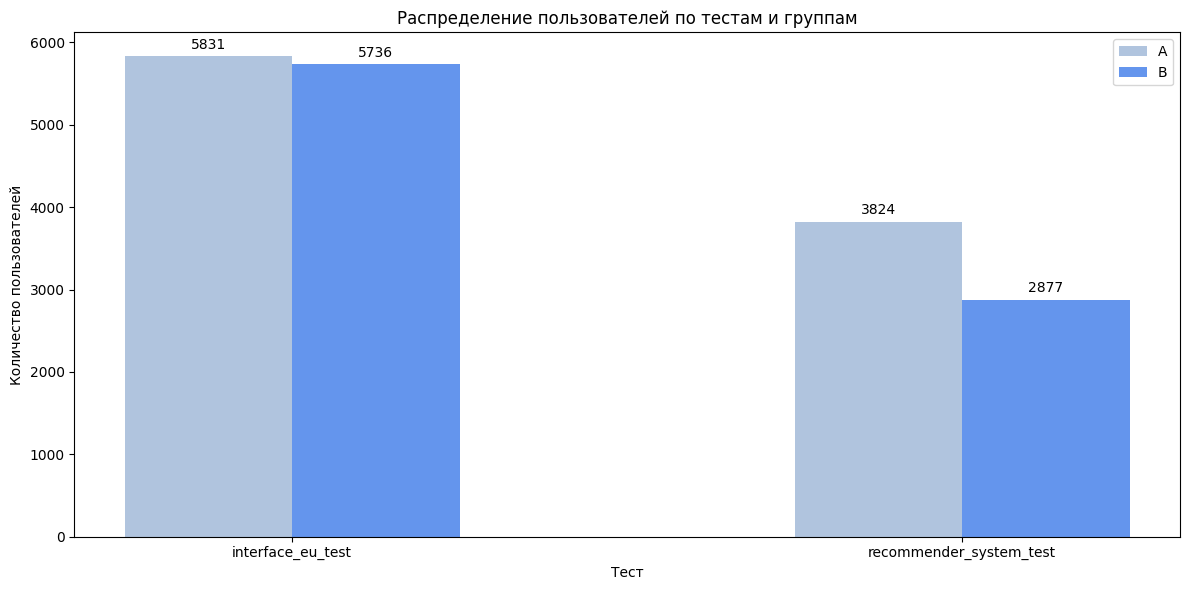

In [39]:
# подготавливаем таблицу количества пользователей в разбивке по типу теста
parallel_tests = final_ab_participants.groupby(['ab_test', 'group']).agg({'user_id':'nunique'}).reset_index()

# строим столбчатую диаграмму 
labels = list(parallel_tests['ab_test'].unique())
one = list(parallel_tests.query('group=="A"')['user_id'])
two = list(parallel_tests.query('group=="B"')['user_id']) 

x = np.arange(len(labels))  # положение подписи
width = 0.5  # ширина столбца

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/4, one, width/2, label='A', color='lightsteelblue')
rects2 = ax.bar(x + width/4, two, width/2, label='B', color='cornflowerblue')

# подписи для оси х и расположение подписи
ax.set_xlabel('Тест')
ax.set_ylabel('Количество пользователей')
ax.set_title('Распределение пользователей по тестам и группам')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """расположение подписи над каждым баром"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() /2, height),
                    xytext=(0, 3),  # положение подписи над баром
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Проверим пересечение пользователей в разных тестах

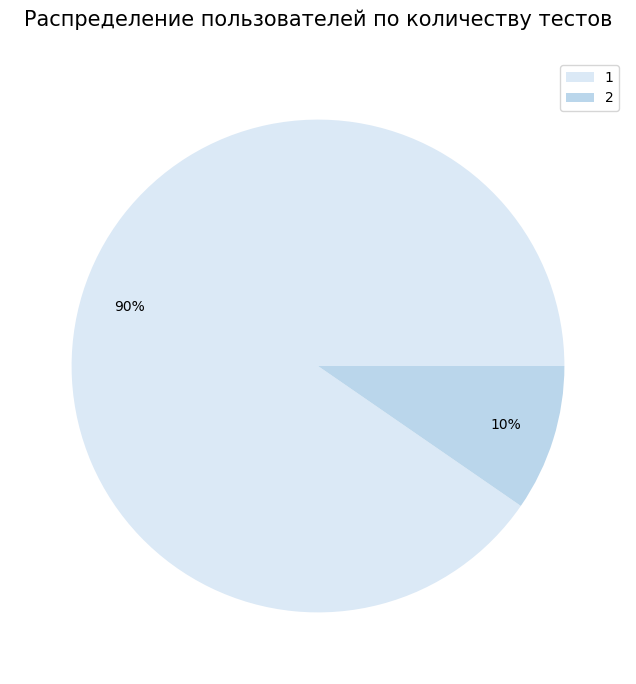

,group,user_id
0,1,15064
1,2,1602


In [40]:
two_tests = (final_ab_participants.groupby('user_id').agg({'group':'count'}).reset_index()
.groupby('group').agg({'user_id':'count'}).reset_index()
)

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(two_tests['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение пользователей по количеству тестов' + "\n", fontsize=15)
plt.legend(two_tests['group'])
plt.show()

two_tests

Из всех пользователей, вовлеченных в проведение теста, 1602 пользователя или 10% принимают участие в двух тестах.

In [41]:
# пользователи, принимающие участие в разных тестах
users_two_groups = final_ab_participants.groupby('user_id').agg({'group':'count'}).query('group > 1').reset_index()

##### Распределение двойных участников по тесту `interface_eu_test`

In [42]:
# участники теста "interface_eu_test"
interface_test = final_ab_participants.query("ab_test == 'interface_eu_test'")

In [43]:
# какое количество пользователей, участвующих в обоих тестах,
# принимает участие в рассматриваемом
interface_test_two = interface_test.query("user_id in @users_two_groups.user_id")
print(f'Количество пользователей, участвующих в двух тестах, составляет '
      f'{interface_test_two["user_id"].nunique()}, что представляет '
      f'{round(interface_test_two["user_id"].nunique()*100/interface_test["user_id"].nunique(),2)}% '
      f'от общего числа участников теста "interface_eu_test".'
)

Количество пользователей, участвующих в двух тестах, составляет 1602, что представляет 13.85% от общего числа участников теста "interface_eu_test".


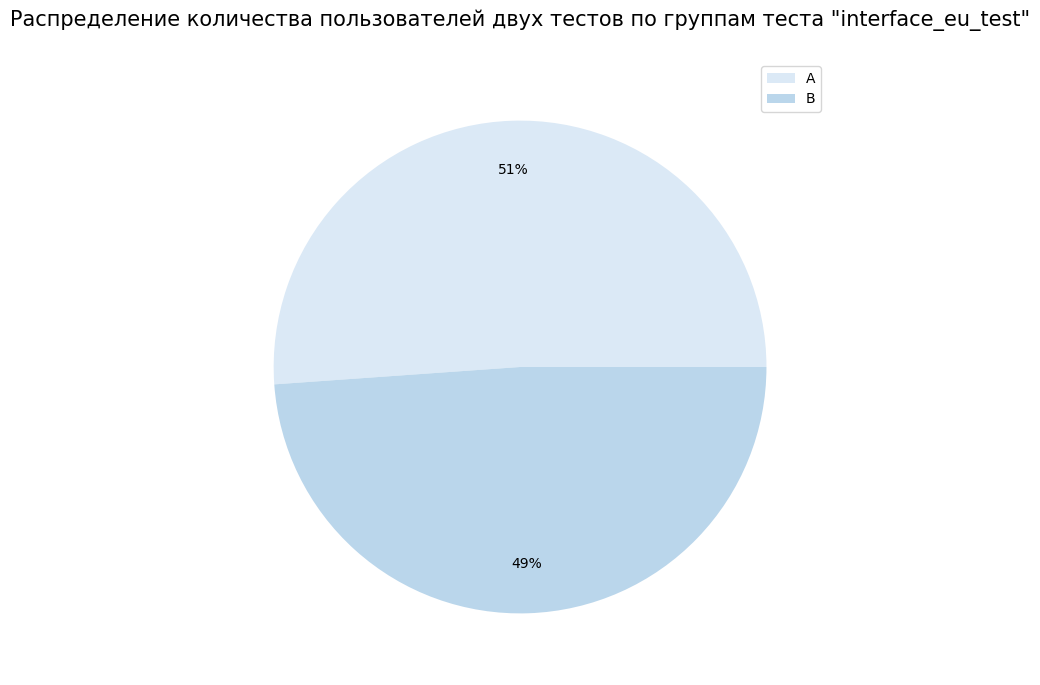

In [44]:
# формируем таблицу по группам теста и посчитаем количество уникальных клиентов, участвующих в нескольких тестах
interface_test_two_group = interface_test_two.groupby('group').agg({'user_id':'nunique'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(interface_test_two_group['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение количества пользователей двух тестов по группам теста "interface_eu_test"' + "\n", fontsize=15)
plt.legend(interface_test_two_group['group'])
plt.show()

Т.е. пользователи, принимающие участие в двух тестах, практически в равной доли распределены в тесте "interface_eu_test". 

##### Распределение двойных участников по тесту `recommender_system_test`

In [45]:
# какое количество пользователей, участвующих в обоих тестах,
# принимает участие в рассматриваемом
audit_test_two = audit_test.query("user_id in @users_two_groups.user_id")
print(f'Количество пользователей, участвующих в двух тестах, составляет '
      f'{audit_test_two["user_id"].nunique()}, что представляет '
      f'{round(audit_test_two["user_id"].nunique()*100/audit_test["user_id"].nunique(),2)}% '
      f'от общего числа участников исследуемого теста.'
)

Количество пользователей, участвующих в двух тестах, составляет 1602, что представляет 23.91% от общего числа участников исследуемого теста.


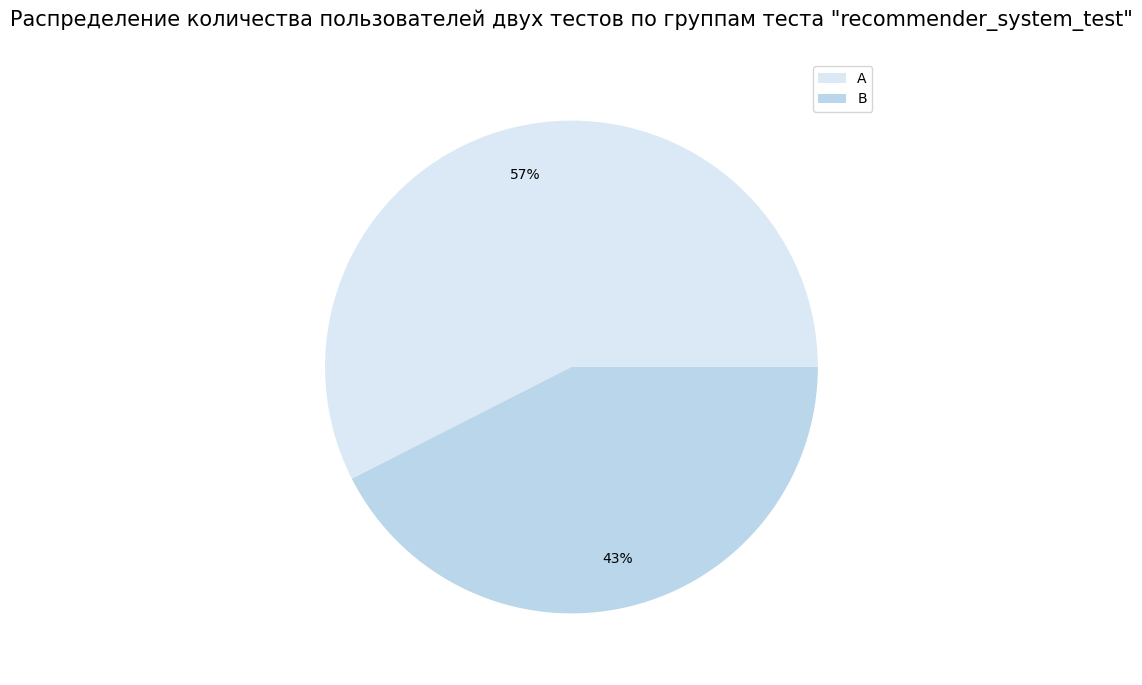

In [46]:
# формируем таблицу по группам теста и посчитаем количество уникальных клиентов, участвующих в нескольких тестах
audit_test_two_group = audit_test_two.groupby('group').agg({'user_id':'nunique'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(audit_test_two_group['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение количества пользователей двух тестов по группам теста "recommender_system_test"' + "\n", fontsize=15)
plt.legend(audit_test_two_group['group'])
plt.show()

Двойные участники принадлежат разным группам теста "recommender_system_test", 57% в группе "А" и 43% в группе "В". 

In [47]:
int_test_b = interface_test_two.query('group == "B"')
audit_test_two_int = (audit_test_two.query('user_id in @int_test_b.user_id')
    .groupby('group').agg({'user_id':'nunique'}).reset_index())
audit_test_two_int

,group,user_id
0,A,439
1,B,344


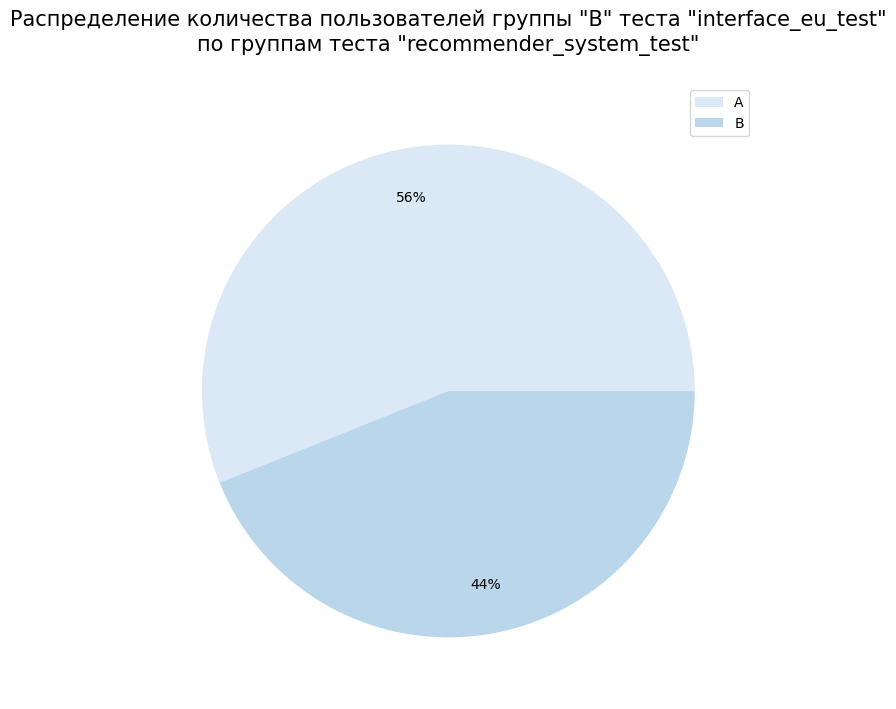

In [48]:
# проверим, в разные ли группы исследуемого теста попадают участники группы "B" теста "interface_eu_test"
int_test_b = interface_test_two.query('group == "B"')
audit_test_two_int = (audit_test_two.query('user_id in @int_test_b.user_id')
    .groupby('group').agg({'user_id':'nunique'}).reset_index())
    

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(audit_test_two_int['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение количества пользователей группы "B" теста "interface_eu_test"' + "\n"
          'по группам теста "recommender_system_test"' + "\n", fontsize=15)
plt.legend(audit_test_two_int['group'])
plt.show()

В соответствии с полученными данными, у нас происходит смешивание разных групп по тестам: участники группы "B" теста "interface_eu_test" присутствуют в обоих группах теста"recommender_system_test". Пользователи группы "В" по первому тесту, с измененным интерфейсом, будут присутствовать и в контрольной группе, и в группе с измененной системой рекомендаций исследуемого теста. При этом если делается акцент на европейскую аудиторию, активность некоторых участников, состоящих в группах "В" по обоим тестам, может отличаться от активности участников исследуемого теста группы "В".

#### Преобразования по требованиям ТЗ

Учитывая, что требования указывают на определенный регион, то оставляем в тесте пользователей Евросоюза, при таком сокращении, аудитория теста все равно остается выше ожидаемого числа в 6000 пользователей.

In [49]:
# оставляем в аудитории теста пользователей из Евросоюза
# добавляем аудитории теста действия
df_test = (
    audit_eu_test
    .merge(audit_test, on='user_id', how='left')
    .merge(final_ab_events, on='user_id', how='left')
)
# добавляем каждому пользователю лайфтайм
df_test['lifetime']= (df_test['day'] - df_test['first_date']).dt.days

Проверим соответствие событий временному интервалу в 14 дней

In [50]:
# сколько записей событий не соответствует требованиям ТЗ по периоду событий
df_test.query('lifetime > 14')['user_id'].count()

592

In [51]:
# количество пользователей, действия которых превышают лайфтайм в 14 дней
df_test.query('lifetime > 14')['user_id'].nunique()

255

В данных присутствуют записи о событиях, превышающих 14 дней, совершенных 255 пользователями. Нам эти данные не требуются, т.к. в ТЗ прописано про увеличение показателя максимус на 14й день, так что исключаем эти данные.

In [52]:
# исключаем не соответствующие данные
df_test = df_test.query('lifetime <=14')

In [53]:
# итоговое количество пользователей
df_test_a = df_test.query('group == "A"')
df_test_b = df_test.query('group == "B"')

print(f'Итоговое количество пользователей Евросоюза, участвующих в тесте составляет {df_test["user_id"].nunique()} '
      f'пользователей, совершивших хотя бы одно действие, '
      f'составляет {round(df_test["user_id"].nunique()*100/audit_eu_test["user_id"].nunique(),2)}% '
      f'от европейских пользователей, заявленных в тест.'
)
print()     
print(f'К группе "А" относится {df_test_a["user_id"].nunique()} пользователей, что составляет '
      f'{round(df_test_a["user_id"].nunique()*100/df_test["user_id"].nunique(),2)}% '
      f'от участников теста, совершивших хотя бы одно действие.'
)
print()     
print(f'К группе "B" относится {df_test_b["user_id"].nunique()} пользователей, что составляет '
      f'{round(df_test_b["user_id"].nunique()*100/df_test["user_id"].nunique(),2)}% '
      f'от участников теста, совершивших хотя бы одно действие.' 
) 

Итоговое количество пользователей Евросоюза, участвующих в тесте составляет 3481 пользователей, совершивших хотя бы одно действие, составляет 54.81% от европейских пользователей, заявленных в тест.

К группе "А" относится 2604 пользователей, что составляет 74.81% от участников теста, совершивших хотя бы одно действие.

К группе "B" относится 877 пользователей, что составляет 25.19% от участников теста, совершивших хотя бы одно действие.


#### Вывод по данным для теста

Зарегестрировано 61 733 новых пользователя, из них у исследуемом тесте участвует 6 701 человек или 10.85%. Из региона EU зарегестрировалось 42 340 пользователей, из них 6 351 участвует в тесте, что соответствует 15% и требованиям ТЗ.

Количество пользователей между группами теста распределено не равномерно, к группе "А" отнесено на 15% больше пользователей.

Динамика регистраций новых пользователей по группам не отличается.

Параллельно в нашим тестом проводится еще один, на изменение интерфейса и направлен на аудиторию Евросоюза. Данных по второму тесту нет, но в нем принимает участие 1602 пользователя нашего теста. Участники двух тестов равномерно распределены в группах параллельного теста, а в нашем с небольшим преимуществом в группе "А" (57.5%). Группы параллельных тестов перемешаны, таким образом пользователи группы "В" второго теста составляют 44% группы "В" исследуемого теста.

Участников теста, совершивших хотя бы одно действие за 14 дней, равно 3481 пользователь, в группе "А" 75%, в группе "В" 25%.

### Шаг 3. Исследовательский анализ данных

#### Характеристика событий

In [54]:
df_user = df_test.groupby('user_id').agg({'event_name':'count'})
df_user.describe()

,event_name
count,3481.000000
mean,6.557886
std,3.765183
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


* Количество подльзователей, совершивших хотя бы одно действие, 3481;
* Среднее количество событий на одного пользователя: 6-7;
* Медианное количество событий на одного пользователя: 6;
* Минимальное количество событий на одного пользователя: 1;
* Максимальное количество событий на одного пользователя: 28;
* Количество пользователей, совершаваших действия в приложении более 9 раз: 25%.

Медиана и среднее отличаются практически равны, но учитывая значение максимального числа событий, пользователей совершивших большие количество событий немного, иначе среднее было бы значительно больше. Для полной картины пользователей можно определить 95 и 99 перцентили количества событий.

In [55]:
np.percentile(df_user['event_name'], [95, 99])

array([15. , 19.2])

Таким образом, пользователей совершивших действия более 15 раз - 5% от общего числа, а более 20 раз - 1%.

In [56]:
# определим количество каждого события
df_event = df_test.groupby('event_name')['user_id'].agg({'count', 'nunique'}).sort_values(by='count',  ascending = False).reset_index()
df_event['ratio_id'] = round(df_event['nunique']/df_test["user_id"].nunique()*100, 2)
df_event

,event_name,count,nunique,ratio_id
0,login,10313,3480,99.97
1,product_page,6382,2178,62.57
2,purchase,3123,1082,31.08
3,product_cart,3010,1026,29.47


Пользователи могут совершать несколько событий:
- вход/ввод логина — `login`,
- просмотр карточек товаров — событие `product_page`,
- просмотры корзины — `product_cart`,
- покупка — `purchase`.

Все уникальные пользователи, совершившие хотя бы одно действие, прошли через ввод логина. 62% пользователей перешло на страницу товара. Дальше идет несоответствие количества событий логичной последовательности шагов воронки, т.к. совершение покупки составляет 31% от всех пользователей, а просмотр корзины меньше, 29%. Соответственно мы имеем либо путь, с которого пользователь попадает может купуть товар в один клик, либо ошибка сбора данных. 

Большое количество пользователей теряется после регистрации, возможно проблемы со входом.

#### Распределение количество событий на пользователя в выборках

In [57]:
# подготавливаем таблицу сгруппированную по дням и группе теста с расчетом событий
user_event = df_test.groupby(['group','user_id']).agg({'event_name':'count'}).reset_index()

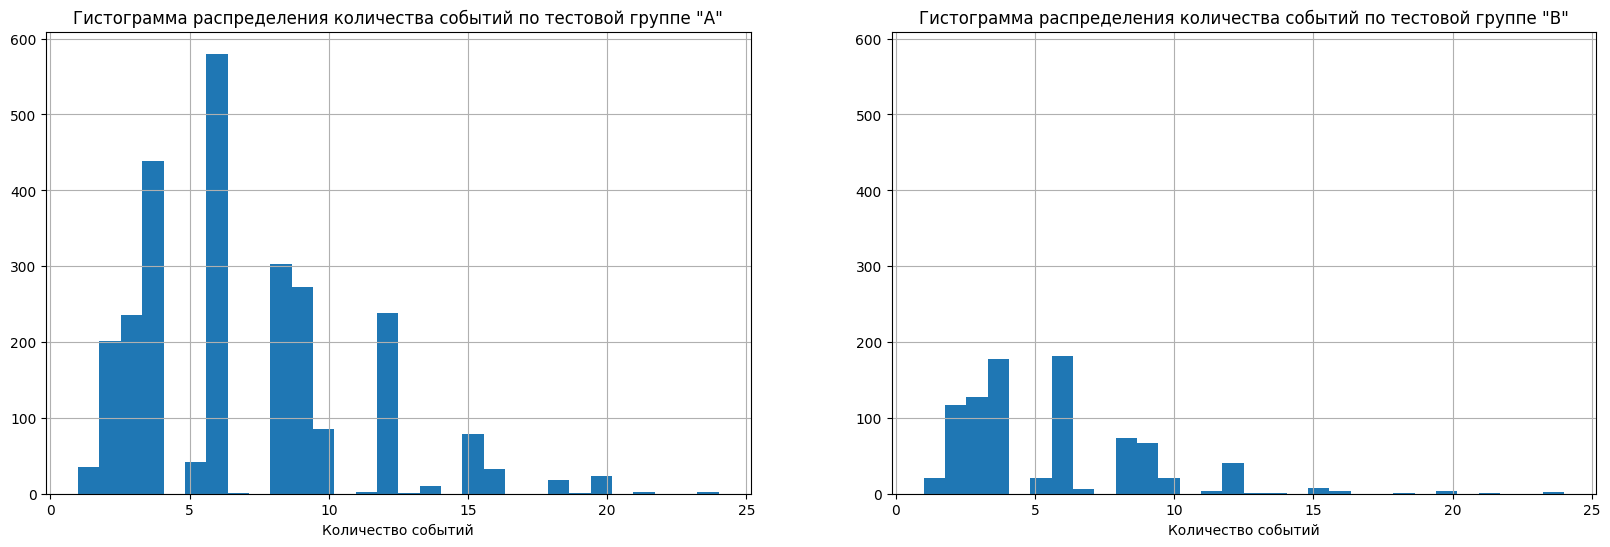

In [58]:
# задаём размер сетки для графиков
plt.figure(figsize=(20, 6))

# в таблице графиков —  одна строка и два столбца, две ячейки
# в первой строим диаграмму размаха общей продолжительности звонков с учетом времени ожидания
ax1 = plt.subplot(1, 2, 1)
(user_event.query('group == "A"')['event_name']).hist(bins=30)
plt.xlabel('Количество событий')
plt.title('Гистограмма распределения количества событий по тестовой группе "А"')

# во второй ячейке гистограмму распределения общей продолжительности звонков с учетом времени ожидания
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
(user_event.query('group == "B"')['event_name']).hist(bins=30)
plt.xlabel('Количество событий')
plt.title('Гистограмма распределения количества событий по тестовой группе "В"')

plt.show()

In [59]:
user_event.groupby('group').agg({'event_name':'mean'}).reset_index()

,group,event_name
0,A,6.903610
1,B,5.531357


Количество событий на пользователя в группе "В" меньше, чем у пользователей группы "А", так в первой клиенты редко совершают больше 12 действий, во втором случае больший процент пользователей совершает 15 количество событий и больше. При этом среднее количество событий на пользователя в группах незначительно отличается.

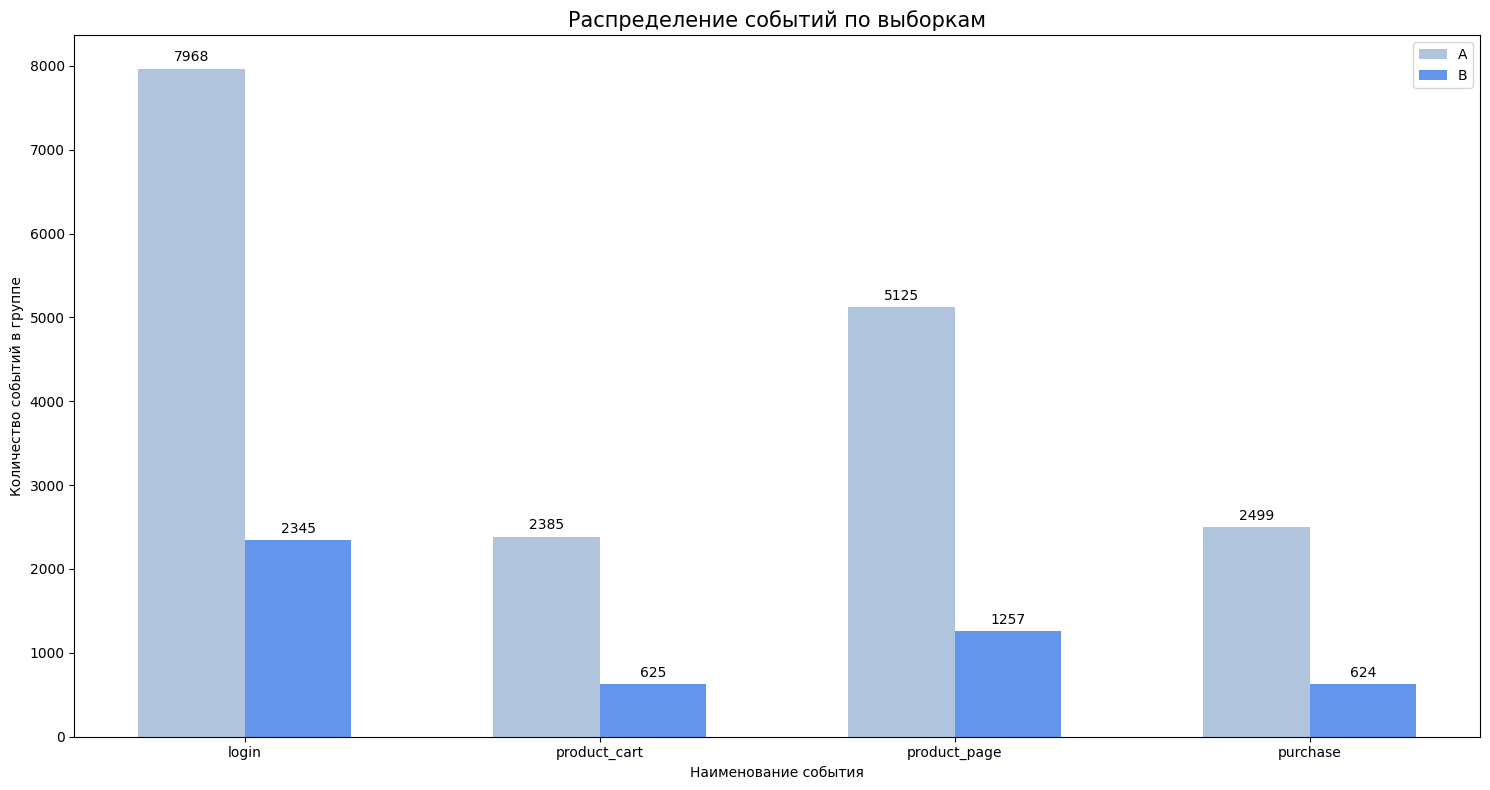

In [60]:
# подготовим таблицу для изучения распределения события по группам
df_test_group_event = df_test.groupby(['group', 'event_name']).agg({'user_id':'count'}).reset_index()

# строим столбчатую диаграмму 
labels = list(df_test_group_event['event_name'].unique())
one = list(df_test_group_event.query('group=="A"')['user_id'])
two = list(df_test_group_event.query('group=="B"')['user_id']) 

x = np.arange(len(labels))  # положение подписи 
width = 0.6  # ширина столбца

fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(x - width/4, one, width/2, label='A', color='lightsteelblue')
rects2 = ax.bar(x + width/4, two, width/2, label='B', color='cornflowerblue')

# подписи для оси х и расположение подписи
ax.set_xlabel('Наименование события')
ax.set_ylabel('Количество событий в группе')
ax.set_title('Распределение событий по выборкам', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """расположение подписи над каждым баром"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() /2, height),
                    xytext=(0, 3),  # расстояние подписи над баром
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Количество событий на группу "В" приходится значительно меньше, во всех типах события пользователи группы "А" совершают в несколько раз больше действий.

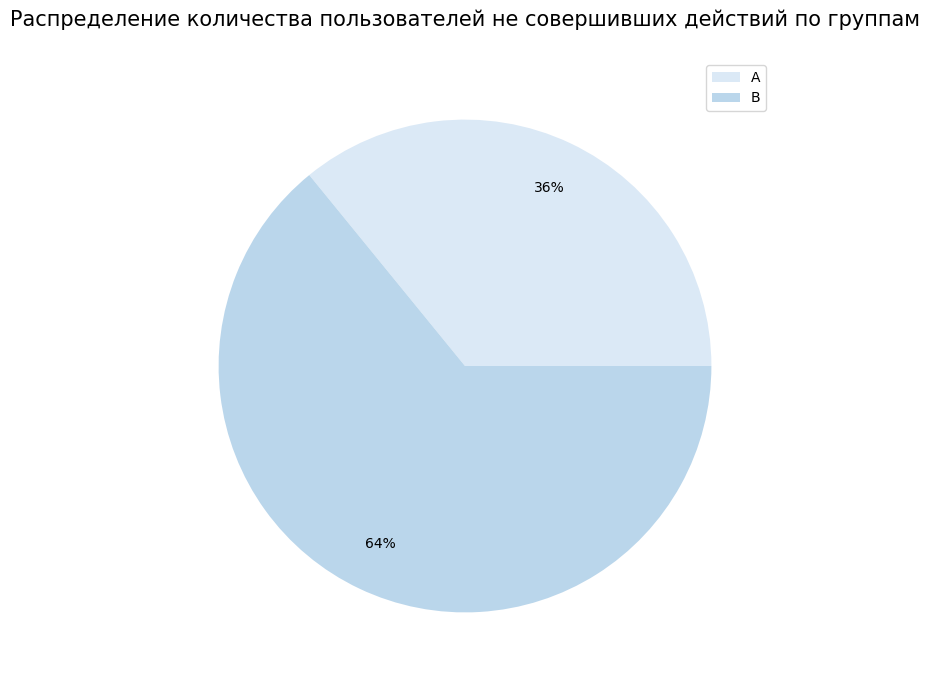

In [61]:
# формируем таблицу по группам теста и посчитаем количество уникальных клиентов, не совершивших действий
audit_no_event = (
    audit_eu_test.query('user_id not in @df_test.user_id')
    .merge(final_ab_participants.query('ab_test == "recommender_system_test"'), on='user_id', how='left')
    )

audit_no_event_ab = audit_no_event.groupby('group').agg({'user_id':'nunique'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(audit_no_event_ab['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение количества пользователей не совершивших действий по группам' + "\n", fontsize=15)
plt.legend(audit_no_event_ab['group'])
plt.show()

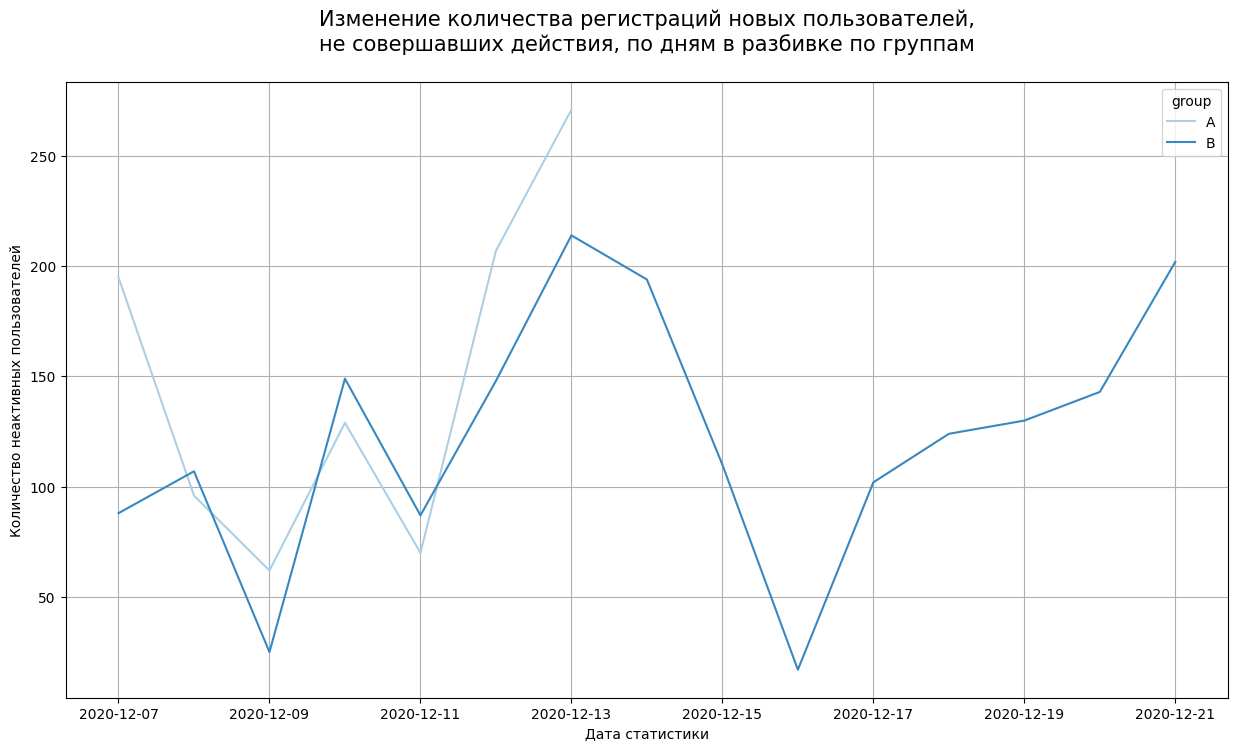

In [62]:
audit_no_event_day = audit_no_event.groupby(['first_date', 'group']).agg({'user_id':'nunique'}).reset_index()

# строим линейный график изменения количества количества событий по дням
plt.figure(figsize=(15,8))
sns.lineplot(data=audit_no_event_day, x='first_date', y='user_id', hue='group', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Количество неактивных пользователей')
plt.title('Изменение количества регистраций новых пользователей,' + "\n" 
          + 'не совершавших действия, по дням в разбивке по группам' + "\n", fontsize=15)
plt.show()

In [63]:
audit_no_event.query('group == "B"').groupby('device').agg({'user_id':'nunique'}).reset_index()

,device,user_id
0,Android,823
1,Mac,176
2,PC,445
3,iPhone,396


Большая часть пользователей, не совершивших действий, относится к группе "В". Может ли это быть связано с изменениями в системе рекомендаций, либо с техническими ошибками сказать сложно. В динамике регистраций, такие пользователи приходили до 13 декабря в обе группы, после попадали только в группу "В". Осебенностей в устройством входа также не обнаружено, неактивные пользователи регестрировались с разных устройств.

#### Распределение событий по дням

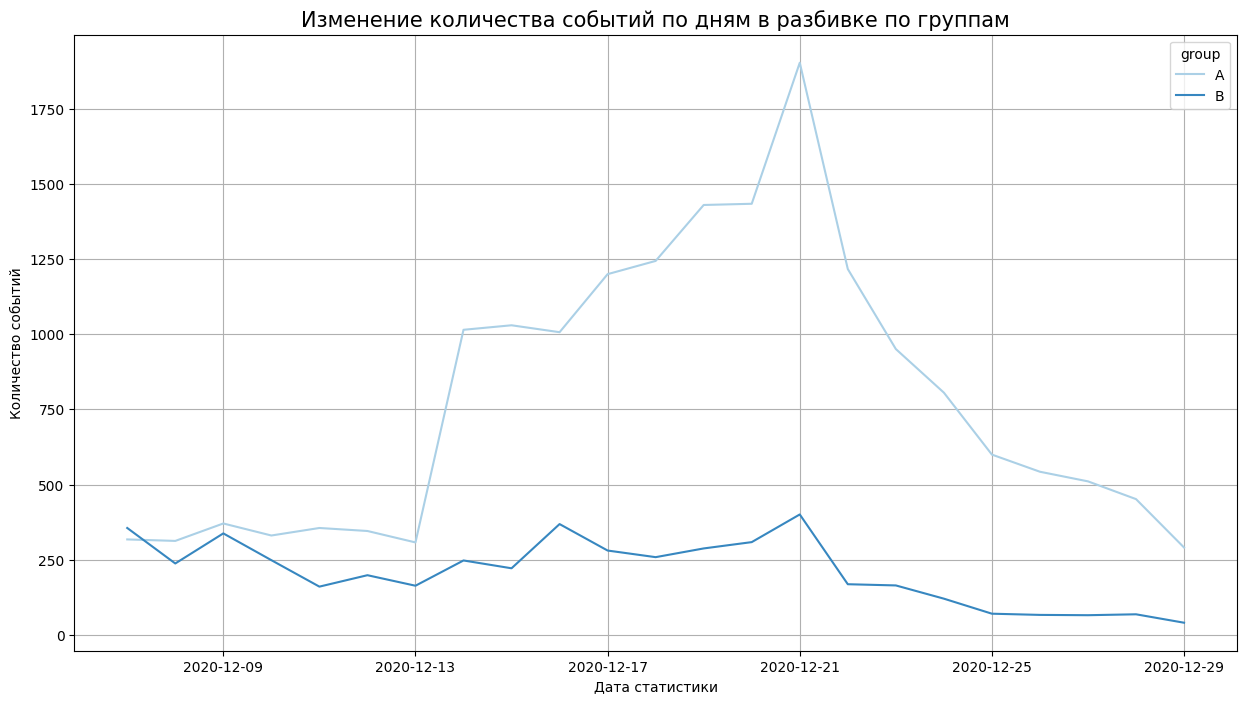

In [64]:
# подготавливаем таблицу сгруппированную по дням и группе теста с расчетом событий
test_day = df_test.groupby(['day', 'group']).agg({'event_name':'count'}).reset_index()

# строим линейный график изменения количества количества событий по дням
plt.figure(figsize=(15,8))
sns.lineplot(data=test_day, x='day', y='event_name', hue='group', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Количество событий')
plt.title('Изменение количества событий по дням в разбивке по группам', fontsize=15)
plt.show()

Изначально особых различий по группам не было, но начиная с 13 декабря пользователи группы "А" резко повышают активность, сохраняя и увеличивая ее до 21 декабря. Затем резкий спад, и окончание полной активности, что подозрительно. Пользователи группы "В" показывают достаточно низкую активность, есть небольшие пики 9, 16 и 21 декабря, после постепенное снижение. 

При этом помним, что 25 декабря запускалась маркетинговая компания, посвященнов рождественским событиям, но какой-либо положительной динамике по событиям не наблюдается.

Проведя параллели с динамикой регистраций новых пользователей из исследовательского анализа с 11 по 14 декабря росло количество пользователей, также с 16 по 21 декабря повышение количества регистраций, что и отображается на графике количества событий.

#### Конверсия в воронке в выборках на разных этапах

In [65]:
# соберем таблицы для каждой группы с группировкой пользователей по событиям для визуализации воронки
# группа "A"
df_group_a = (
    df_test.query('group == "A"')
    .groupby('event_name').agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False).reset_index())
df_group_a.columns = ['event_name', 'A']
df_group_a = df_group_a.reindex([0, 1, 3, 2])
df_group_a['conv_a'] = df_group_a['A'].shift()
df_group_a['conv_a'] = df_group_a['conv_a'].fillna (df_group_a['conv_a'].max())
df_group_a['conv_a'] = round(df_group_a['A']/df_group_a['conv_a']*100, 2)
df_group_a = round(df_group_a.assign(conv_a_by_first = lambda x: x['A']/x['A'].max()*100), 2)

# группа "B"
df_group_b = (
    df_test.query('group == "B"')
    .groupby('event_name').agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False).reset_index())
df_group_b.columns = ['event_name', 'B']
df_group_b = df_group_b.reindex([0, 1, 3, 2])
df_group_b['conv_b'] = df_group_b['B'].shift() #считаем конверсию группы "B"
df_group_b['conv_b'] = df_group_b['conv_b'].fillna(df_group_b['conv_b'].max())
df_group_b['conv_b'] = round(df_group_b['B']/df_group_b['conv_b']*100, 2)
df_group_b = round(df_group_b.assign(conv_b_by_first = lambda x: x['B']/x['B'].max()*100), 2)

df_group = (
    df_group_a.merge(
    df_group_b, on='event_name', how='left')
)

In [66]:
df_group

,event_name,A,conv_a,conv_a_by_first,B,conv_b,conv_b_by_first
0,login,2604,100.00,100.00,876,100.00,100.00
1,product_page,1685,64.71,64.71,493,56.28,56.28
2,product_cart,782,46.41,30.03,244,49.49,27.85
3,purchase,833,106.52,31.99,249,102.05,28.42


In [67]:
# строим график воронки
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = df_group['event_name'].tolist(),
    x = df_group['A'].tolist(),
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = df_group['event_name'].tolist(),
    x = df_group['B'].tolist(),
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"))

fig.update_layout(
    title={
        'text': "Воронка событий по группам в долях",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Последовательные шаги воронки событий",
    width=800, height=600)
fig.show()

Воронка представляет собой цепь событий: вход ➡ посещение главной товара ➡ корзина ➡ покупка. 

Первый шаг включает в себя всех пользователей. 
Далее теряется более 30% пользователей, и на просмотр товара уже попадает 65% пользователей от группы "А" и 56% пользователей от группы "В". В корзину уже попадает 46% пользователей группы "А" и 49,5% группы "В". Делаем вывод о непоследовательной воронки событий, т.к. количество пользователей, оформавших покупку, больше пользователей, прошедших через корзину, и составляет по группе "А" 32%, по группе "В" 28%.

#### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Критерии успешного теста: 
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. 
- Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно;
- Следует подготовить данные в соответствием с ТЗ;
- Предусмотреть время проведение теста, сочетание и возможное влияние маркетинговых событий.

### Шаг 4. Анализ результатов теста


#### Что можно сказать про результаты A/В-тестирования?

Количество участников теста, соверающих действия не соответствует требованиям задания. 

Распредение участников на группы также не равномерно, группа "А" по размеру в несколько раз превышает группы "В". 

Конверсия в группе "В" превышает группу "А" на переходе от сабытия просмотра какрточки товара к корзине на 3%.

#### Проверьте статистическую разницу долей z-критерием.

**Гипотезы**
 
 Нулевая гипотеза: различий в долях пользователей, совершивших событие, между группами нет. 
 
 Альтернативная гипотеза: различия долей по совершению события между группами есть.

Используем статистический критерий для проверки - `z-тест для пропорций`


In [68]:
# таблица для первой группы
df_group1 = (df_test.query('group == "A"')
                .groupby('event_name').agg({'user_id':'nunique'})
                .sort_values(by='user_id', ascending=False).reset_index())
    
# таблица для второй группы
df_group2 = (df_test.query('group ==  "B"')
                .groupby('event_name').agg({'user_id':'nunique'})
                .sort_values(by='user_id', ascending=False).reset_index())

# таблица с количеством уникальных пользователей на группу
df_group_count = df_test.groupby('group', as_index = False).agg({'user_id': 'nunique'})

# уникальные пользователи первой группы    
count1 = df_group_count[df_group_count.isin(["A"]).any(axis= 1)].reset_index()
count1 = count1.loc[0]['user_id']

# уникальные пользователи второй группы      
count2 = df_group_count[df_group_count.isin(["B"]).any(axis= 1)].reset_index()
count2 = count2.loc[0]['user_id']

for event in df_test['event_name'].unique():
    # количество пользователей на событие
    x = df_group1[df_group1.isin([event]).any(axis= 1)].reset_index()
    x = x.loc[0]['user_id']
    
    y = df_group2[df_group2.isin([event]).any(axis= 1)].reset_index()
    y = y.loc[0]['user_id']

    successes = np.array([x, y])
    trials = np.array([count1, count2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    print(successes[0], successes[1], trials[0], trials[1])

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # статистический уровнь значимости alpha 
    # применеие поправки на множественную проверку гипотез - поправку Бонферони
    alpha = 0.05/4

    p_value = (1 - distr.cdf(abs(z_value)))*2

    print('Событие ', event)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )    

1685 493 2604 877
Событие  product_page
p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
2604 876 2604 877
Событие  login
p-значение:  0.08481837035887363
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
833 249 2604 877
Событие  purchase
p-значение:  0.04652482738393027
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
782 244 2604 877
Событие  product_cart
p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Общие выводы

Воронка представляет собой цепь событий: вход ➡ посещение главной товара ➡ корзина ➡ покупка. 

Все пользователи начинают взаимодействие со входа, но затем более 30% теряется. Поток пользователей с шага на шаг воронки неравномерный, также присутствует не прямой переход с шага на шаг, т.к. количество пользователей, оформивших покупку, больше пользователей, прошедших через корзину, и составляет по группе "А" 32%, по группе "В" 28%.

Проверка гипотезы о равенстве долей показала, что между группами теста - "А" и "В"  нет статистически значимых различий по всем событиям, кроме просмотра корзины. На просмотр корзины в группе "В" конверсия на 3% больше, чем в группе "А".

В данном случае, полагалось бы сделать вывод о том, что новая система рекомендаций не повлияла на действия пользователя, т.к. повышение метрик на 10% не наблюдается ни по одному из событий. 

Однако, следует учитывать комплекс проблем, связанных с проведением теста:

1. Аудитория теста

Обнаружено 45% неактивных пользователей от европейских участников теста, большая часть которых относится к группе "В", что значительно изменило распределение пользователей по тестовым группам в пользу группы "А". Регистрация неактивных пользователей выполнялась весь период набора в тестовые группы, с устройством входа нет аномальных результатов, следует проверить на факт наличия технических ошибок в логировании таких пользователей.

Итого, в результате произошло сокращение выборок. 

Часть пользователей участвует в параллельном тесте, к тому же пользователи группы "В" являются участниками группы "В" другого теста.

2. Время проведения теста

Время теста определено было на конец года, а новогодние праздники характеризуются повышенной активностью. Но даже этот факт не отражен в динамике активности пользователей.

Также вся активность прекращена 30 декабря, за 5 дней до окончания теста, что не характерно для обычного поведения пользователей, также следует проверить на технические ошибки либо со стороны взаимодействия пользователя с платформой либо в сборе данных.

3. Увеличесние бизнес-метрик на 10%

Увеличение конверсии в группе "В" относительно группы "А" замечено только на шаге перехода к корзине, в остальных событиях меньше.

4. Результаты теста

Статистическая разница обнаружена только на событии перехода пользователя в корзину. В остальном между выборками нет различий. Также следует учитывать, что размер выборок уменьшился, что могло повлиять на фиксацию различий.

Принято решение не доверять результатам теста, исследовать возникающие проблемы во взаимодейтвие пользователей с ситемой, при устранении технических проблем и учете сезонности повторить проведение теста.